In [75]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

/Users/apple/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [79]:
data_path = 'data_prepared/mergedAB_delete_all_empty.csv'


In [80]:
data = pd.read_csv(data_path, header= None)

/Users/apple/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
header = list(['feature'+str(i) for i in range(45)])
header[-1] = 'label'
data.columns = header

In [86]:
data_ori = data[data.label!='0'][data.label!='null']
label = [float(x) for x in data_ori.label]

0.605116520923244

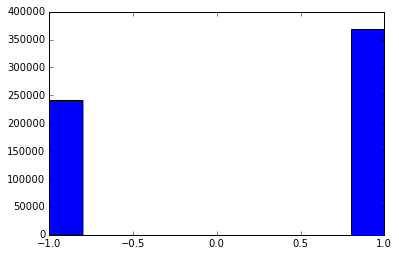

In [70]:
% matplotlib inline
plt.hist(label)
368899/(368899+240734)


In [87]:
dataset = data_ori
dataset['label'] = label

In [98]:
len(dataset)

609633

# Decision Tree

In [109]:
probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])

In [111]:
fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])

In [114]:
thresholds

array([ 2.,  1.,  0.])

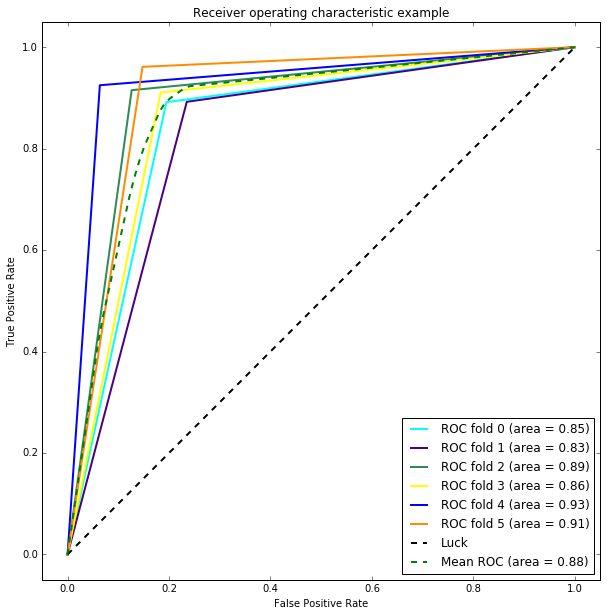

In [137]:
X, y = dataset.drop(['label'],axis=1), dataset['label']
X = np.array(X)
y = np.array(y)
cv = StratifiedKFold(n_splits=6)
classifier = tree.DecisionTreeClassifier()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
plt.figure(figsize = (10,10))
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [144]:
# Using those arrays, we can parse the tree structure:
estimator = classifier
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %ss else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] != node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[i, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

The binary tree structure has 19719 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 34] <= 2571.41967773s else to node 16208.
	node=1 test node: go to node 2 if X[:, 34] <= 2457.90820312s else to node 13171.
		node=2 test node: go to node 3 if X[:, 5] <= 152.5s else to node 11302.
			node=3 test node: go to node 4 if X[:, 6] <= 0.135849624872s else to node 7867.
				node=4 test node: go to node 5 if X[:, 34] <= 2377.02099609s else to node 6022.
					node=5 test node: go to node 6 if X[:, 33] <= 1618.23413086s else to node 5785.
						node=6 test node: go to node 7 if X[:, 34] <= 2265.25048828s else to node 3734.
							node=7 test node: go to node 8 if X[:, 33] <= 1502.67749023s else to node 3591.
								node=8 test node: go to node 9 if X[:, 32] <= 450.199829102s else to node 1246.
									node=9 test node: go to node 10 if X[:, 32] <= 449.77746582s else to node 1237.
										node=10 test node: go to node 11 if X[:, 36] <= 1349.35864258s else to 

/Users/apple/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/apple/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


																			node=14034 test node: go to node 14035 if X[:, 1] <= 10.5s else to node 14046.
																				node=14035 test node: go to node 14036 if X[:, 34] <= 2503.35913086s else to node 14045.
																					node=14036 test node: go to node 14037 if X[:, 24] <= 483.049987793s else to node 14044.
																						node=14037 test node: go to node 14038 if X[:, 43] <= 2677.36425781s else to node 14043.
																							node=14038 test node: go to node 14039 if X[:, 16] <= 459.850006104s else to node 14040.
																								node=14039 leaf node.
																								node=14040 test node: go to node 14041 if X[:, 0] <= 466.900024414s else to node 14042.
																									node=14041 leaf node.
																									node=14042 leaf node.
																							node=14043 leaf node.
																						node=14044 leaf node.
																					node=14045 leaf node.
																				node=14046 test node: go to node 14047 if X[:, 33] <= 18

In [148]:
np.log2(19719)

14.267298770432534

In [149]:
2**13

8192

In [142]:
classifier.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [108]:
fpr

array([ 0.        ,  0.15056577,  1.        ])

# SVM

In [122]:
# Normalization
import sklearn
Feature=sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True).fit_transform(data_ori.drop(['label'],1))
names=list(data_ori.columns.values)
Feature=pd.DataFrame(Feature,columns=names[:-1])


df_normal=Feature
df_normal['label']=list(data_ori['label'])


In [125]:
df_normal.to_csv('./data_prepared/mergedAB_delete_all_empty_normal.csv', index=False)

# Logistic Regression

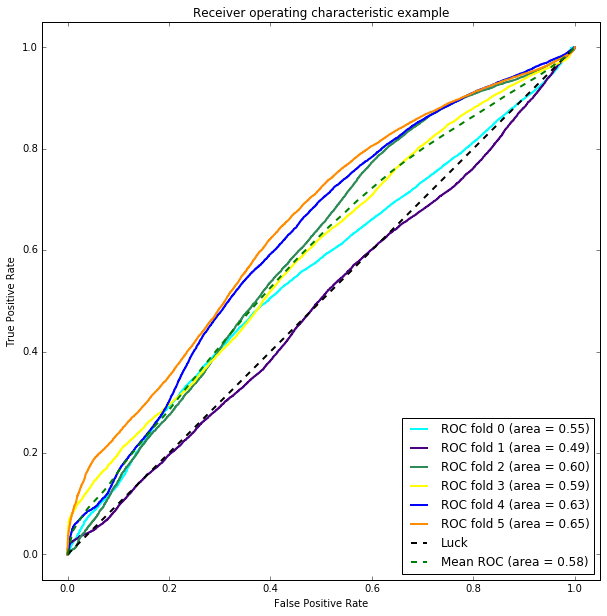

In [134]:
from sklearn.linear_model import LogisticRegression
X, y = df_normal.drop(['label'],axis=1), dataset['label']
X = np.array(X)
y = np.array(y)
cv = StratifiedKFold(n_splits=6)
classifier = LogisticRegression()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
plt.figure(figsize = (10,10))
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# AdaBoost

In [151]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier
n_estimators = 100
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = .1

X, y = df_normal.drop(['label'],axis=1), dataset['label']
X = np.array(X)
y = np.array(y)

X_test, y_test = X[480000:], y[480000:]
X_train, y_train = X[:480000], y[:480000]

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=15, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='Real AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

KeyboardInterrupt: 

# Splitting by Speaker 

In [166]:
IDdata_path = 'data_prepared/mergedAB_delete_all_empty_with_ID.csv'

In [169]:
IDdata = pd.read_csv(IDdata_path, header= None)

/Users/apple/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
ID = IDdata[0]

In [172]:
header = list(['feature'+str(i) for i in range(46)])
header[-1] = 'label'
header[0]='ID'
IDdata.columns = header

In [187]:
data_ori = IDdata[IDdata.label!='0'][IDdata.label!='null']
label = [float(x) for x in data_ori.label]
dataID = data_ori
dataID['label'] = label
dataID.index = dataID['ID']
data_well = dataID.drop(['ID'],1)

In [189]:
label_speaker = dataID.groupby(['ID'])['label'].mean()
speaker = list(label_speaker.index)

In [215]:
# Normalization
import sklearn
Feature=sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True).fit_transform(data_well.drop(['label'],1))
names=list(data_well.columns.values)
Feature=pd.DataFrame(Feature,columns=names[:-1])


IDdf_normal=Feature
IDdf_normal['label']=list(data_well['label'])

IDdf_normal.index= data_well.index

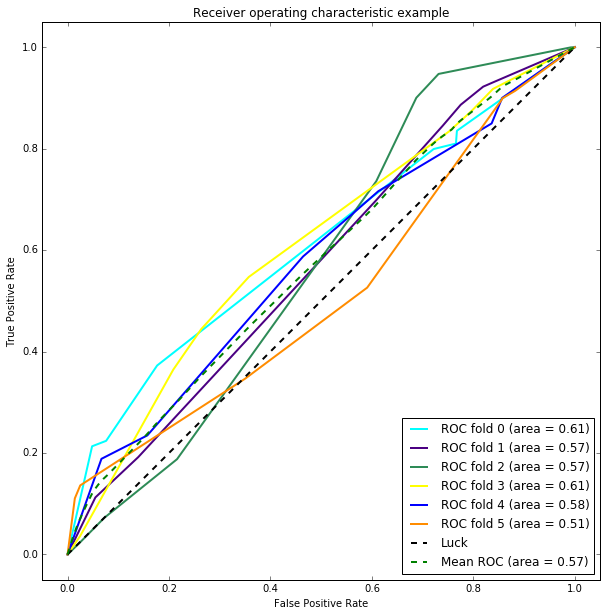

In [224]:
# Decision Tree
X, y = data_well.drop(['label'],axis=1), data_well['label']

cv = StratifiedKFold(n_splits=6)
classifier = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=300)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
plt.figure(figsize = (10,10))
for (train, test), color in zip(cv.split(speaker,label_speaker), colors):
    train_s = speaker[train]
    test_s = speaker[test]
    
    probas_ = classifier.fit(X.ix[train_s], y.ix[train_s]).predict_proba(X.ix[test_s])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.ix[test_s], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(speaker,label_speaker)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

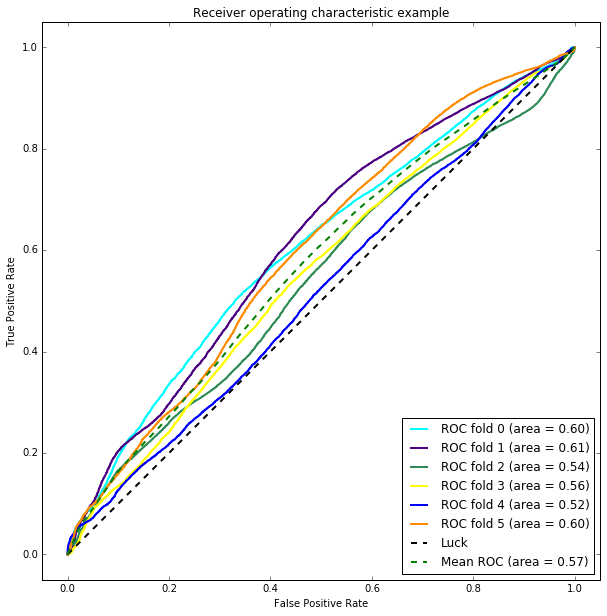

In [219]:
# Logistic Regression
X, y = IDdf_normal.drop(['label'],axis=1), IDdf_normal['label']

cv = StratifiedKFold(n_splits=6)
classifier = LogisticRegression()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
plt.figure(figsize = (10,10))
for (train, test), color in zip(cv.split(speaker,label_speaker), colors):
    train_s = speaker[train]
    test_s = speaker[test]
    
    probas_ = classifier.fit(X.ix[train_s], y.ix[train_s]).predict_proba(X.ix[test_s])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.ix[test_s], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(speaker,label_speaker)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

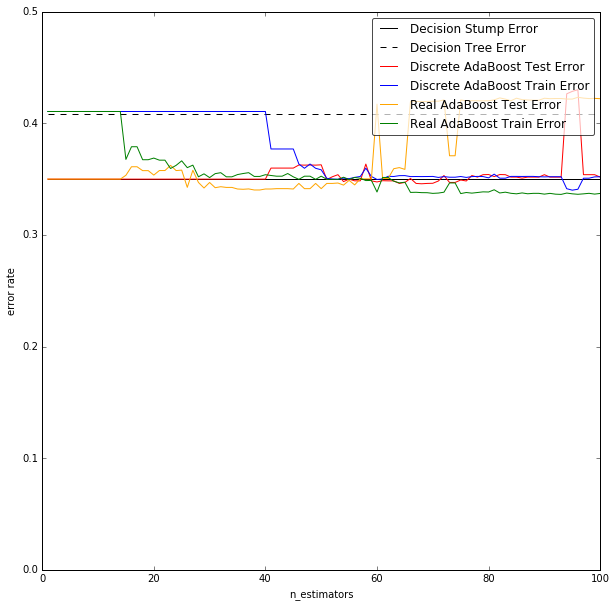

In [220]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier
n_estimators = 100
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = .1
X, y = data_well.drop(['label'],axis=1), data_well['label']



X_test, y_test = X.ix[speaker[300:]], y.ix[speaker[300:]]
X_train, y_train = X.ix[speaker[:300]], y.ix[speaker[:300]]

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='Real AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()